# First steps 

In [2]:
# Use python 3.7.10

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
plt.style.use('dark_background')

In [3]:
# load the dataset
PATH = '/Users/dj/Documents/GitHub/Time-Series-Forecasting-with-Python/Time-Series-Forecasting-with-Python'
df = pd.read_csv( PATH + '/AirPassengers.csv')
df = df.rename(columns={"Month": "Month", "#Passengers": "Passengers"})
print(df.dtypes) # We can see that month is of type object, therefore it will be changed to datetime

Month         object
Passengers     int64
dtype: object


Month         datetime64[ns]
Passengers             int64
dtype: object


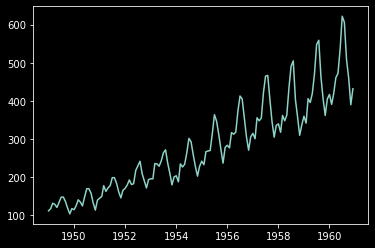

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

df.set_index('Month', inplace=True) # Use the given time and turn it into the idex

plt.plot(df['Passengers'])

In [5]:
#Is the data stationary?
#Dickey-Fuller test
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [6]:
df['year'] = [d.year for d in df.index] # Create a new colum which has the extracted year from our index column
df['month'] = [d.strftime('%b') for d in df.index] # Same but with year
years = df['year'].unique()

In [7]:
df['month'][0]

'Jan'

<AxesSubplot:xlabel='year', ylabel='Passengers'>

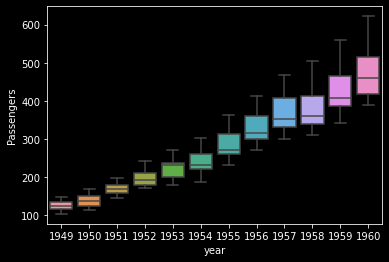

In [8]:
#Plot yearly and monthly values as boxplot
sns.boxplot(x='year', y='Passengers', data=df)

<AxesSubplot:xlabel='month', ylabel='Passengers'>

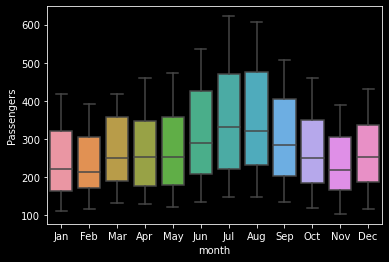

In [9]:
sns.boxplot(x='month', y='Passengers', data=df)

In [10]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')


In [11]:
#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

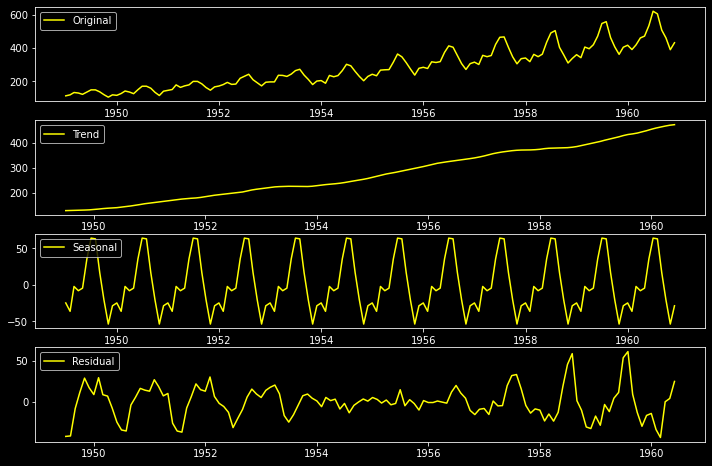

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


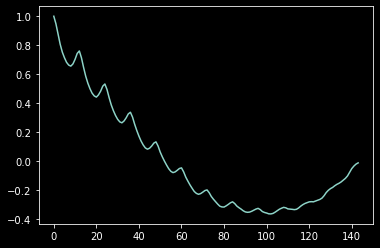

In [13]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf
acf_144 = acf(df.Passengers, nlags=144)
plt.plot(acf_144)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

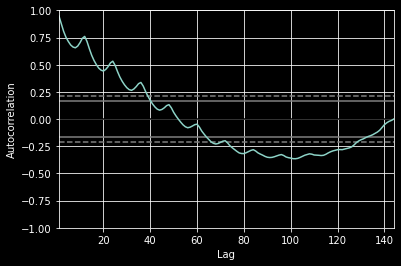

In [14]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Passengers) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

# ARIMA

In [15]:
#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)

from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.19 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.25 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.38 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [16]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Wed, 08 Dec 2021   AIC                           1019.178
Time:                                     19:49:37   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [17]:
#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Wed, 08 Dec 2021   AIC                            610.538
Time:                                    19:49:38   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.369
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3227      0.103     -3.138      0.002      -0.524      -0.121
ar.S.L12       0.6849      0.625      1.095      0.273      -0.541       1.911
ar.S.L24       0.3141      0.137      2.290      0.022       0.045       0.583
ma.S.L12      -0.9826      6.103     -0.161      0.872     -12.945      10.980
sigma2        78.4360    429.525      0.183      0.855    -763.417     920.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.58
Prob(Q):                              0.93   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.43
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) # Predict insample - which is not that interesting

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')  # Predict out of sample
#Rename the column

<AxesSubplot:xlabel='Month'>

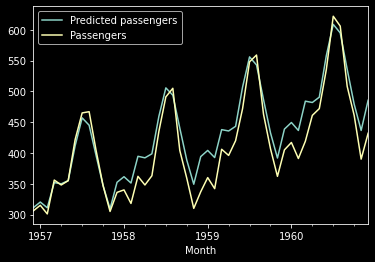

In [19]:
# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 


In [20]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train["Passengers"], train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test['Passengers'], prediction))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 16.14 RMSE
Test Score: 29.44 RMSE


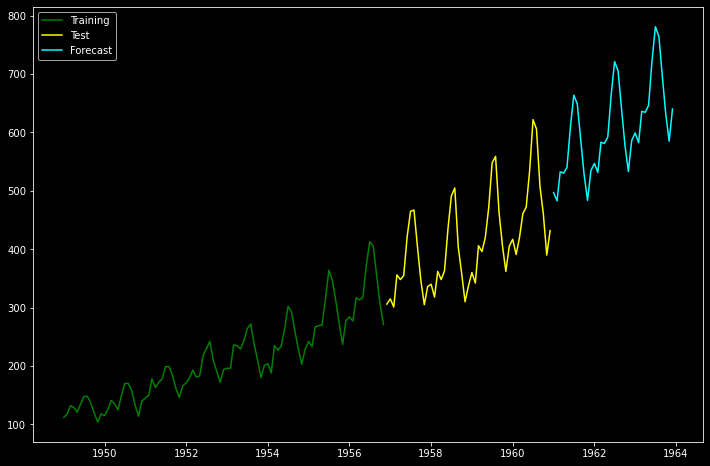

In [21]:
#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train["Passengers"], label='Training', color='green')
plt.plot(X_test["Passengers"], label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()

# FFNN

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

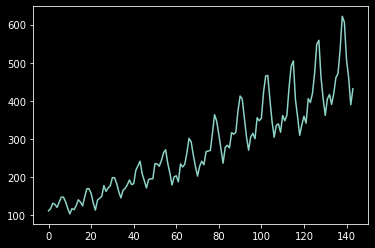

In [23]:
# load the dataset
dataframe = read_csv(PATH + '/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [24]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [25]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [26]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [27]:
seq_size = 20 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
# trainX, trainY = to_sequences(train, seq_size)
# testX, testY = to_sequences(test, seq_size)

In [28]:
#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#With length 40 it generated 55 samples, each of length 40 (by using data of length 95)

Total number of samples in the original training data =  95
Total number of samples in the generated data =  75


In [29]:
#Also generate validation data
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)


# Building the FFNN

In [30]:
#Input dimensions are... (N x seq_size)
print('Build feed forward NN model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

Build feed forward NN model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)


Epoch 1/100
 - 1s - loss: 0.0145 - acc: 0.0000e+00 - val_loss: 3.2258e-04 - val_acc: 0.0345
Epoch 2/100
 - 0s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 6.5601e-06 - val_acc: 0.0345
Epoch 3/100
 - 0s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 4.4904e-06 - val_acc: 0.0345
Epoch 4/100
 - 0s - loss: 0.0024 - acc: 0.0000e+00 - val_loss: 8.3719e-04 - val_acc: 0.0345
Epoch 5/100
 - 0s - loss: 0.0016 - acc: 0.0000e+00 - val_loss: 6.7331e-04 - val_acc: 0.0345
Epoch 6/100
 - 0s - loss: 0.0015 - acc: 0.0000e+00 - val_loss: 1.1071e-04 - val_acc: 0.0345
Epoch 7/100
 - 0s - loss: 0.0015 - acc: 0.0000e+00 - val_loss: 2.5996e-05 - val_acc: 0.0345
Epoch 8/100
 - 0s - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 7.8045e-04 - val_acc: 0.0345
Epoch 9/100
 - 0s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0345
Epoch 10/100
 - 0s - loss: 9.9011e-04 - acc: 0.0000e+00 - val_loss: 0.0078 - val_acc: 0.0345
Epoch 11/100
 - 0s - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0136 - val_acc: 0

In [32]:
# make predictions

trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

In [33]:
# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

In [34]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.82 RMSE
Test Score: 22.12 RMSE


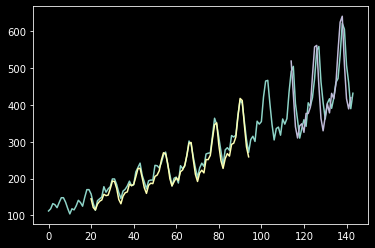

In [35]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()